# Sleep Quality Analysis with Machine Learning

## 1. Introduction

The project studies how sleep duration and quality change day-by-day, and how behavior during the previous day affects sleep. The sleep-related factors such as caffeine consumption, activity or stress could have a big impact on sleep. The objective of this project is to find patterns in sleep quality by examining relationshops between sleep and other factors.

- Add literature!
- Motivation for the research question!

## 2. Problem formulation

Placeholder

## 3. Dataset description

The dataset contains sleep-related information that was collected by Dana Diotte between the years 2014 – 2018. Data is Diotte’s personal data from the Sleep Cycle application form Northcube. The dataset was published on the website Kaggle.com.
There are in total 887 observations from different days. There are no observations from each day, but from those days that there are, the dataset is mostly well-filled and there is not too much missing data. Ten variables were tracked: Start, End, Sleep quality, Time in bed, Wake up, Sleep Notes, Heart rate, and Activity. The dataset is in .csv format. The dataset is available at: https://www.kaggle.com/datasets/danagerous/sleep-data?select=sleepdata.csv. A second sleep dataset was published later by Diotte to Kaggle. The tracked variables were partly different, and for that reason, in this study only sleepdata.csv is used and sleepdata_2.csv is ignored.

The dataset was cleaned by removing rows with missing data. In the cleaning process it turned out that variables "Hearth rate" and "Wake up" were not appearing with the variable "Activity (steps)". Apparently tracking "Heart rate" and "Wake up" was stopped at some point and "Activity (steps)" was tracked only from August 2016 onwards. As "Activity (steps)" was an interesting variable for analysis, and the other two variables had far less data points, "Heart rate" and "Wake up" were discarded in the cleaning. The number of remaining rows after the cleaning was 254.

Five new variables were extracted from “Sleep Notes”: “Coffee”, “Tea”, “Working out”, “Late eating” and “Stress”. These are binary features that define if these events occurred during the observation day. “Sleep Notes” consisted only of these five markings and thus it was pruned out from the dataset as redundant.

One more new feature "Weekend" was extracted using feature "Start". "Weekend" is a binary feature that defines if an observation is recorded on weekend or not. This feature was created because, there is more time to sleep on weekends typically, which could also have an effect on sleep quality, and on the other hand there could be more social events on weekends which could also affect sleep. In this feature Friday-Saturday, observations from Saturday-Sunday and Sunday-Monday nights are considered as weekend. Although, interesting findings could have been made from sleep starting time and ending times, this was out of the scope of this project and “Start” and “End” were discarded.

In the end, the dataset contained the variables listed in Table 1.


| Name          | Data type   | Description |
| ------------- | ----------- | ----------- |
| Sleep quality | integer [0,100] | Quality of sleep|
| Time in bed   | integer     |Minutes in bed|
| Activity (steps)   | integer     |Number of steps|
| Coffee   | binary     |Drinking coffee at some point of a day|
| Tea   | binary     |Drinking tea at some point of a day|
| Working out  | binary     |Working out at some point of a day|
| Late eating  | binary    |Eating late|
| Stress | binary     |Stress during the day|
| Weekend  | binary    |Observation on Friday - Sunday|
| Late to bed | binary    |Going to bed between 00:00 - 05:59|

                                                        Table 1

## 3.1 Exploratory analysis

In [133]:
# Importing libraries
import pandas as pd
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.svm import SVR 
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
import numpy as np

### sleepdata.csv (Dataset 1)

In [32]:
# Dataset
sleepdata = pd.read_csv("sleepdata.csv", sep = ";")

row, col = sleepdata.shape

print("The first dataset contains", row, "rows and", col, "columns.")

The first dataset contains 887 rows and 8 columns.


In [4]:
sleepdata.head()

,Start,End,Sleep quality,Time in bed,Wake up,Sleep Notes,Heart rate,Activity (steps)
0,2014-12-29 22:57:49,2014-12-30 07:30:13,100%,8:32,:),NaN,59.0,0
1,2014-12-30 21:17:50,2014-12-30 21:33:54,3%,0:16,:|,Stressful day,72.0,0
2,2014-12-30 22:42:49,2014-12-31 07:13:31,98%,8:30,:|,NaN,57.0,0
3,2014-12-31 22:31:01,2015-01-01 06:03:01,65%,7:32,NaN,NaN,NaN,0
4,2015-01-01 22:12:10,2015-01-02 04:56:35,72%,6:44,:),Drank coffee:Drank tea,68.0,0


In [5]:
sleepdata.dtypes

Start                object
End                  object
Sleep quality        object
Time in bed          object
Wake up              object
Sleep Notes          object
Heart rate          float64
Activity (steps)      int64
dtype: object

In [6]:
sleepdata.isnull().sum(axis = 0)

Start                 0
End                   0
Sleep quality         0
Time in bed           0
Wake up             641
Sleep Notes         235
Heart rate          725
Activity (steps)      0
dtype: int64

### sleepdata_2.csv (Dataset 2)

In [7]:
# Dataset
sleepdata2 = data = pd.read_csv("sleepdata_2.csv", sep = ";")

row, col = sleepdata2.shape

print("The second dataset contains", row, "rows and", col, "columns")

The second dataset contains 921 rows and 21 columns


In [8]:
sleepdata2.isnull().sum(axis = 0)

Start                            0
End                              0
Sleep Quality                    0
Regularity                       0
Mood                           921
Heart rate (bpm)                 0
Steps                            0
Alarm mode                       0
Air Pressure (Pa)              429
City                           434
Movements per hour               0
Time in bed (seconds)            0
Time asleep (seconds)            0
Time before sleep (seconds)      0
Window start                    80
Window stop                     80
Did snore                        0
Snore time                       0
Weather temperature (°C)         0
Weather type                     0
Notes                          912
dtype: int64

## 3.2 Data Pre-processing

In [102]:
data_cleaned = sleepdata.copy()

# Dropping columns "End", "Wake up" "Heart rate"
data_cleaned = data_cleaned.drop(["End", "Wake up", "Heart rate"], axis = 1)

# Dropping rows where "Sleep quality", "Sleep Notes" or is NA
data_cleaned = data_cleaned.dropna(subset = ["Sleep quality", "Sleep Notes"])

# Droppin rows where "Activity (steps)" is zero
data_cleaned.drop(data_cleaned[data_cleaned["Activity (steps)"] == 0].index, inplace = True)

# Modifying "Time in bed" into minutes
data_cleaned = data_cleaned.reset_index(drop=True)

for row in range(data_cleaned.shape[0]):
    str_time = data_cleaned["Time in bed"][row]
    if str_time[1] == ":":
        data_cleaned["Time in bed"][row] = int(int(data_cleaned["Time in bed"][row][0]) * 60 + int(data_cleaned["Time in bed"][row][2:4]))
    else:
        data_cleaned["Time in bed"][row] = int(data_cleaned["Time in bed"][row][0:2]) * 60 + int(data_cleaned["Time in bed"][row][3:5])

# Modifying "Sleep quality" into an integer and "Time in bed into a numeric"
data_cleaned["Sleep quality"] = data_cleaned["Sleep quality"].apply(lambda row: int(row[:-1]))
data_cleaned["Time in bed"] = pd.to_numeric(data_cleaned["Time in bed"])

# Creating Late to Bed
data_cleaned["Late to bed"] = pd.to_datetime(data_cleaned["Start"]).dt.hour.map(lambda x: int(x < 6 and x >= 0))

# Creating Weekend and Weekday Features
data_cleaned["Start"] = pd.to_datetime(data_cleaned["Start"]).dt.date
data_cleaned["Weekend"] = pd.to_datetime(data_cleaned["Start"]).dt.dayofweek
days = {0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}
data_cleaned["Weekday"] = data_cleaned.Weekend.map(days)
data_cleaned["Weekend"] = data_cleaned["Weekend"].apply(lambda row: int(row == 4 or row == 5 or row == 6))

# The number of remaining rows
print("The number of remaining rows is", data_cleaned.shape[0])

# Showing the results
data_cleaned.head()

data_cleaned

/tmp/ipykernel_146/405692125.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cleaned["Time in bed"][row] = int(int(data_cleaned["Time in bed"][row][0]) * 60 + int(data_cleaned["Time in bed"][row][2:4]))
/tmp/ipykernel_146/405692125.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cleaned["Time in bed"][row] = int(data_cleaned["Time in bed"][row][0:2]) * 60 + int(data_cleaned["Time in bed"][row][3:5])


The number of remaining rows is 254


,Start,Sleep quality,Time in bed,Sleep Notes,Activity (steps),Late to bed,Weekend,Weekday
0,2016-08-17,78,453,Ate late:Drank coffee:Worked out,7200,0,0,Wednesday
1,2016-08-18,36,504,Drank coffee:Worked out,3444,0,0,Thursday
2,2016-08-20,56,628,Drank coffee,7901,0,1,Saturday
3,2016-08-21,52,491,Drank coffee:Drank tea,3786,0,1,Sunday
4,2016-08-22,35,489,Drank coffee:Worked out,2668,0,0,Monday
...,...,...,...,...,...,...,...,...
249,2017-06-04,67,426,Drank coffee,6705,0,1,Sunday
250,2017-06-05,74,467,Drank coffee:Worked out,7820,0,0,Monday
251,2017-06-06,76,494,Drank coffee:Drank tea:Stressful day:Worked out,5391,0,0,Tuesday
252,2017-06-07,41,460,Drank coffee:Drank tea:Worked out,10542,0,0,Wednesday


In [103]:
# Encoding Sleep Notes into variables
data_cleaned["Sleep Notes"].value_counts()

Drank coffee:Drank tea                             63
Drank coffee:Drank tea:Worked out                  61
Drank tea                                          38
Drank tea:Worked out                               34
Drank coffee:Worked out                            22
Drank coffee                                       19
Drank coffee:Drank tea:Stressful day                4
Drank coffee:Drank tea:Stressful day:Worked out     3
Ate late:Drank coffee:Worked out                    2
Drank tea:Stressful day:Worked out                  2
Drank coffee:Stressful day:Worked out               2
Ate late:Drank coffee:Drank tea:Worked out          2
Drank coffee:Stressful day                          1
Ate late:Drank coffee:Drank tea                     1
Name: Sleep Notes, dtype: int64

In [104]:
# Coffee
data_cleaned["Coffee"] = data_cleaned["Sleep Notes"].apply(lambda row: int("coffee" in row))

# Tea
data_cleaned["Tea"] = data_cleaned["Sleep Notes"].apply(lambda row: int("tea" in row))

# Working out
data_cleaned["Working out"] = data_cleaned["Sleep Notes"].apply(lambda row: int("Worked" in row))

# Late eating
data_cleaned["Late eating"] = data_cleaned["Sleep Notes"].apply(lambda row: int("Ate late" in row))

# Stress
data_cleaned["Stress"] = data_cleaned["Sleep Notes"].apply(lambda row: int("Stressful" in row))

# Dropping "Sleep Notes"g
data_cleaned = data_cleaned.drop(["Sleep Notes"], axis = 1)

data_cleaned.head()

,Start,Sleep quality,Time in bed,Activity (steps),Late to bed,Weekend,Weekday,Coffee,Tea,Working out,Late eating,Stress
0,2016-08-17,78,453,7200,0,0,Wednesday,1,0,1,1,0
1,2016-08-18,36,504,3444,0,0,Thursday,1,0,1,0,0
2,2016-08-20,56,628,7901,0,1,Saturday,1,0,0,0,0
3,2016-08-21,52,491,3786,0,1,Sunday,1,1,0,0,0
4,2016-08-22,35,489,2668,0,0,Monday,1,0,1,0,0


## 3.3 Exploratory visualization

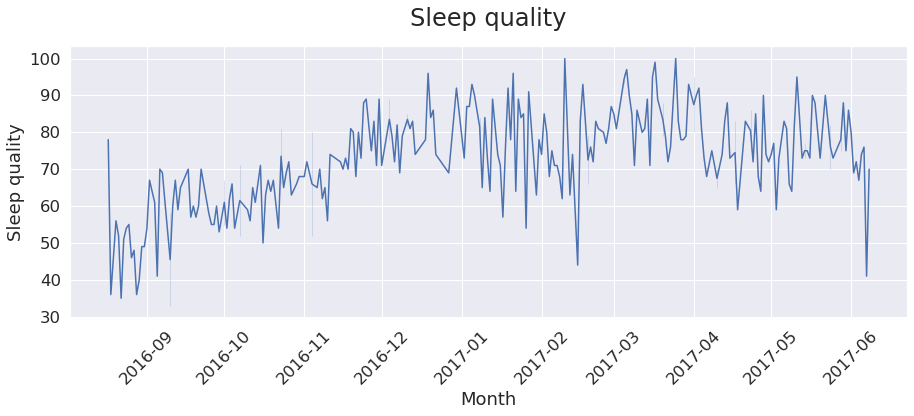

In [105]:
plt.figure(figsize=(15,5))

sns.lineplot(y = data_cleaned["Sleep quality"], x = data_cleaned["Start"])

plt.title("Sleep quality", pad=20, fontsize=24)
plt.xlabel("Month")
plt.xticks(rotation=45)
plt.savefig('Sleep_quality_trendline.png')
plt.show()

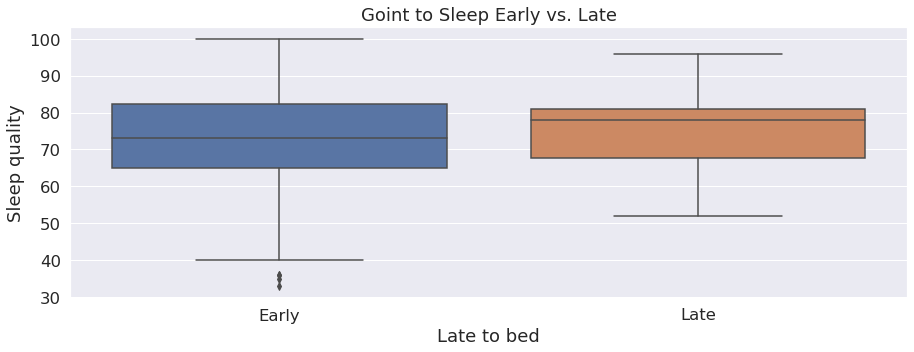

In [106]:
# Initialize a figure
plt.figure(figsize=(15,5))

# Make a boxplot with seaborn
ax = sns.boxplot(x=data_cleaned['Late to bed'], y=data_cleaned['Sleep quality'])
plt.title("Goint to Sleep Early vs. Late")
ax.set_xticklabels(["Early", "Late"])

plt.show()

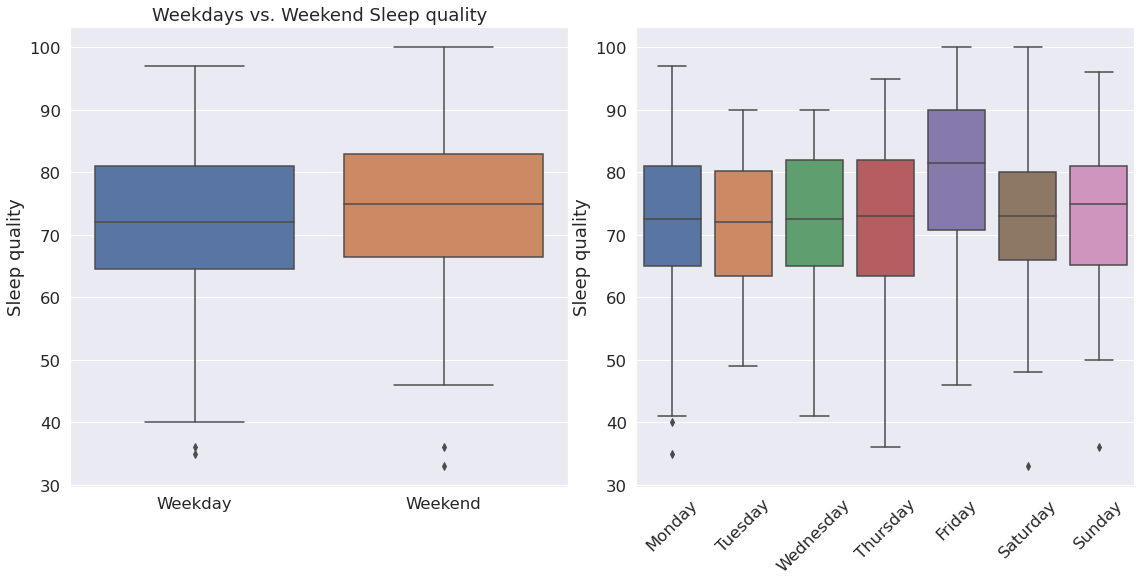

In [107]:
# Initialize a figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (16,8))
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

# Make a boxplot with seaborn
sns.boxplot(x=data_cleaned['Weekend'], y=data_cleaned['Sleep quality'], ax=ax1)
ax1.set_title("Weekdays vs. Weekend Sleep quality")
ax1.set_xticklabels(["Weekday", "Weekend"])
ax1.set(xlabel=None)


# Make a boxplot with seaborn
sns.boxplot(x=data_cleaned['Weekday'], y=data_cleaned['Sleep quality'], ax=ax2, order = order)
ax2.set_xlabel("Weekday")
ax2.set(xlabel=None)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation = 45)
plt.savefig('Sleep_quality_weekday.png')
plt.show()

In [108]:
data_cleaned = data_cleaned.drop(["Start", "Weekday"], axis = 1)

# 4. Methods

Placeholder

Descriptive 

- Limitations of the methods

## 4.1 Feature Selection

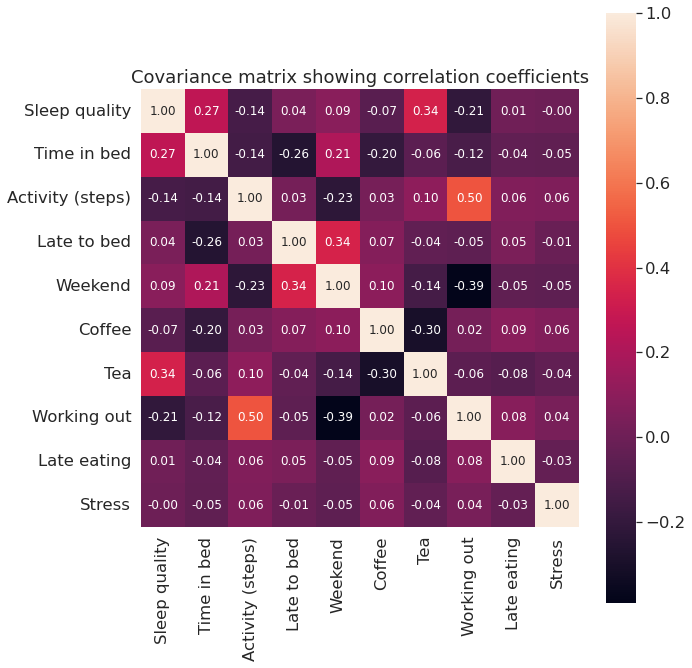

In [109]:
# Covariance matrix
plt.figure(figsize=(10,10))
sns.set(font_scale=1.5)
hm = sns.heatmap(data_cleaned.corr(),
                 cbar=True,
                 annot=True,
                 square=True,
                 fmt='.2f',
                 annot_kws={'size': 12})
plt.title('Covariance matrix showing correlation coefficients')
plt.tight_layout() 
plt.savefig('Correlation_matrix.png')
plt.show() 

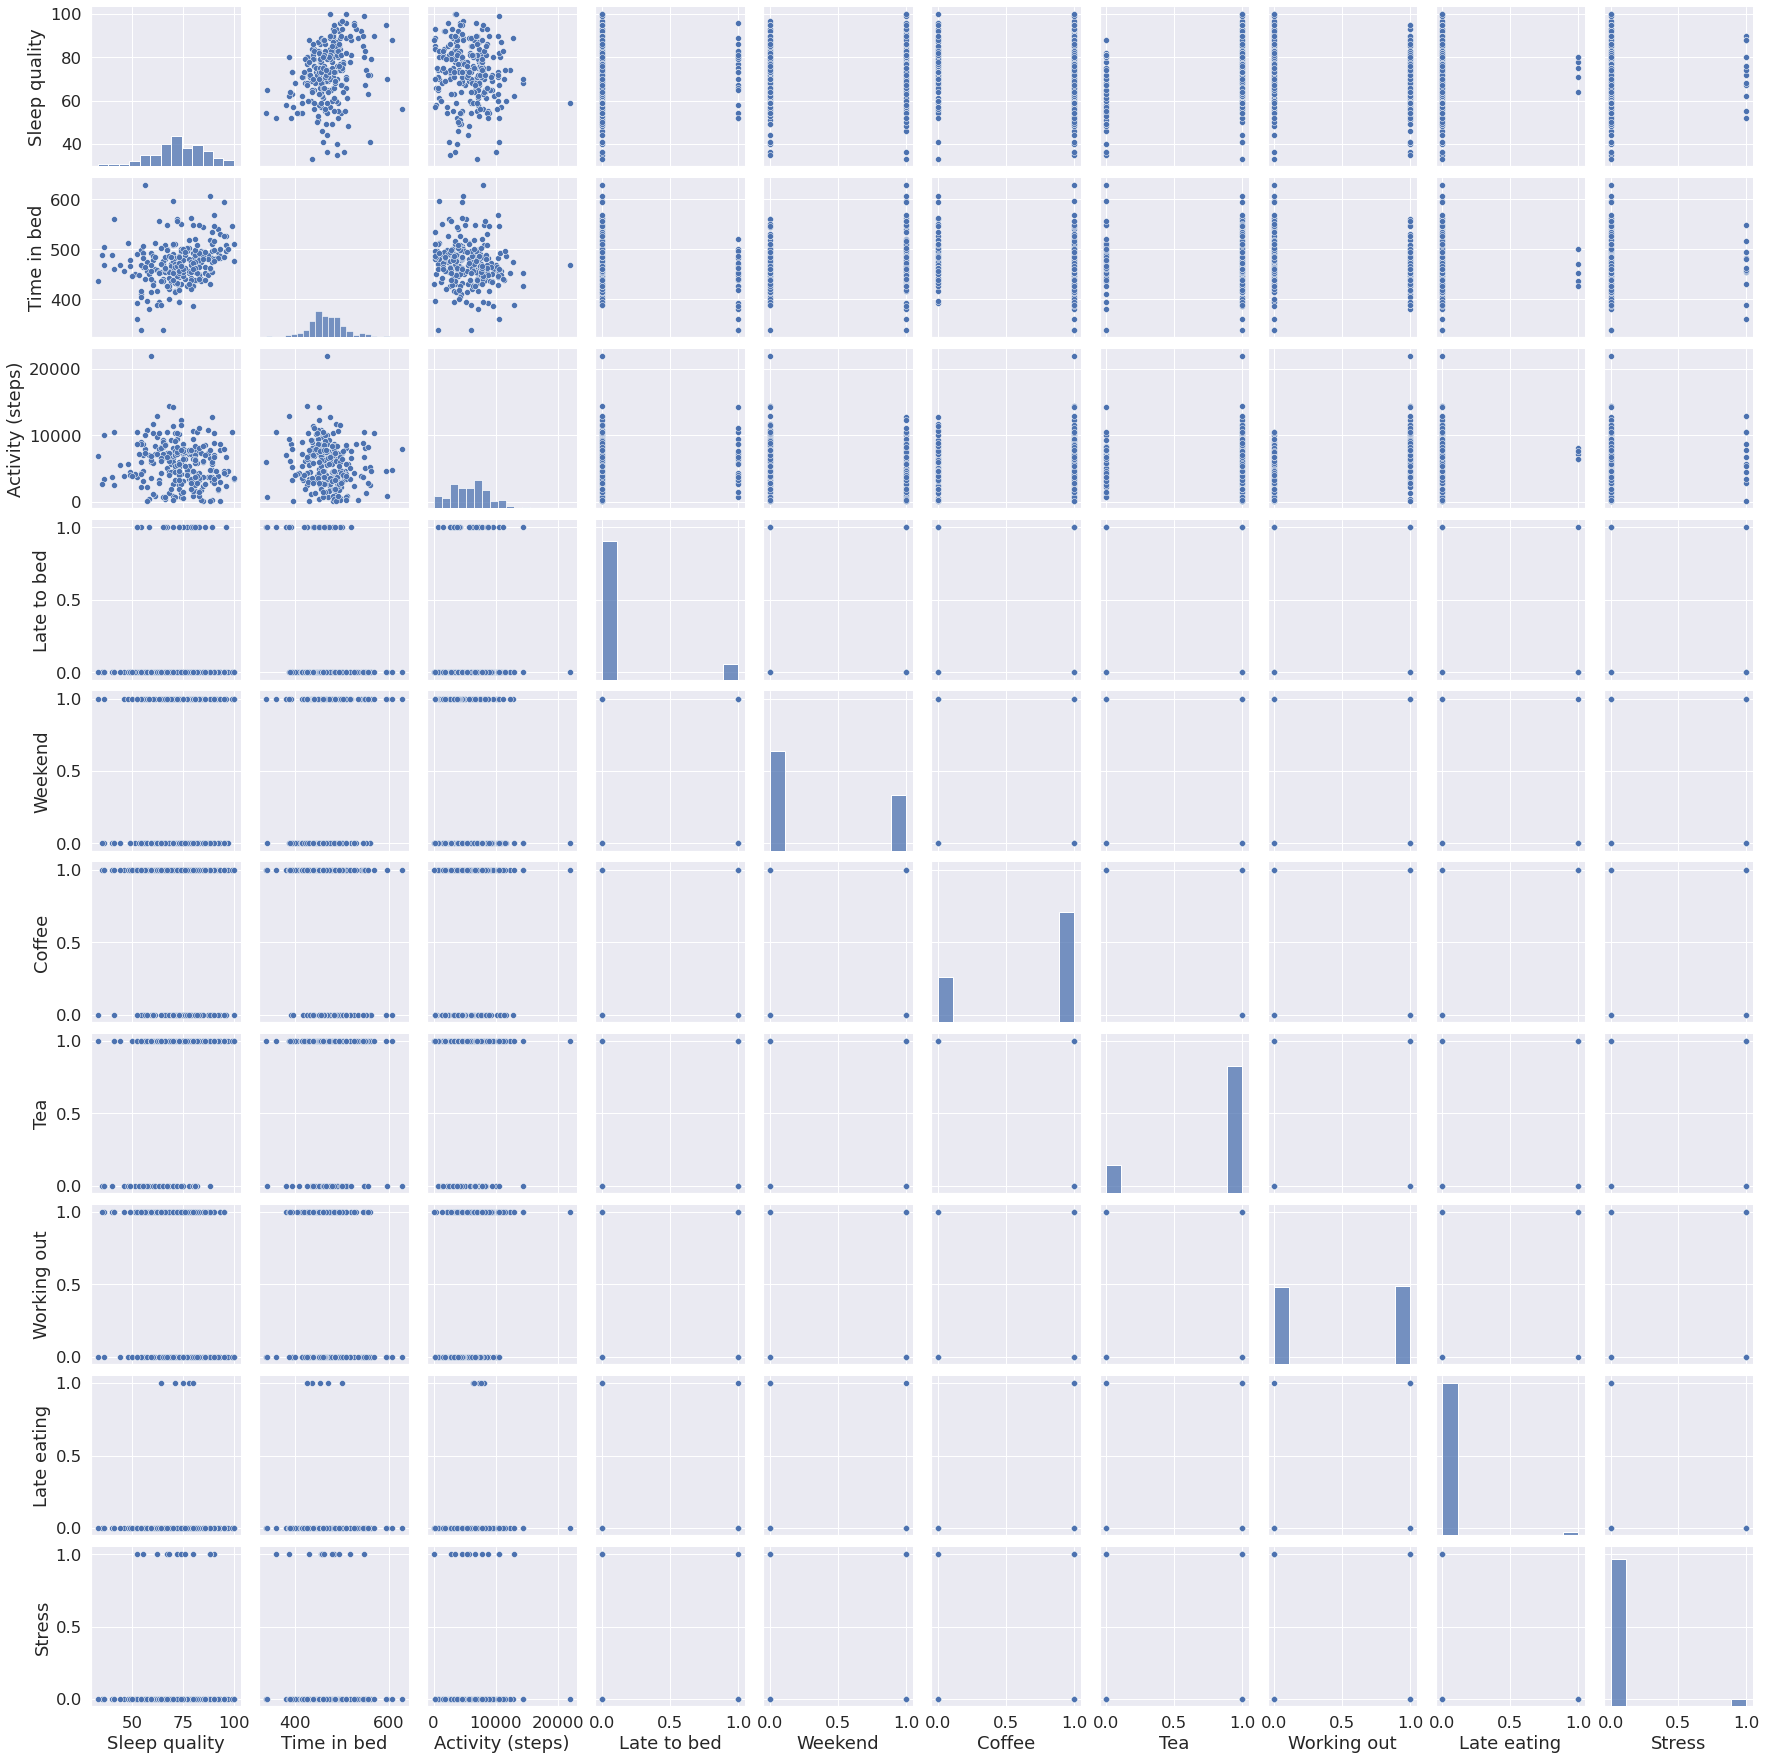

In [110]:
sns.pairplot(data_cleaned)
plt.savefig('Pairplot.png')
plt.show()

## 4.2 Wrapper Method for Feature Selection

In [112]:
y = data_cleaned.iloc[:, 0]
X = data_cleaned.iloc[:, 1:]

# Scaling
scaler = StandardScaler()
X_names = list(X.columns.values)
X = pd.DataFrame(scaler.fit_transform(X))
X.columns = X_names

X_train, X_test = data_cleaned.iloc[:230, 1:], data_cleaned.iloc[230:, 1:]
y_train, y_test = data_cleaned.iloc[:230, 0], data_cleaned.iloc[230:, 0]

# Regressors
lin_reg = LinearRegression()
svr = SVR()

# Sequential feature selection
lin_reg_sfs = SequentialFeatureSelector(lin_reg)
svr_sfs = SequentialFeatureSelector(svr)

lin_reg_sfs.fit(X_train, y_train)
svr_sfs.fit(X_train, y_train)

SequentialFeatureSelector(estimator=LinearRegression(), direction = "backward")
SequentialFeatureSelector(estimator=SVR(), direction = "backward")

print("The proposed variables with the linear regression are:", lin_reg_sfs.get_feature_names_out())
print("The proposed variables with the support vector regressor are:", svr_sfs.get_feature_names_out())

The proposed variables with the linear regression are: ['Time in bed' 'Late to bed' 'Tea' 'Working out']
The proposed variables with the support vector regressor are: ['Tea' 'Working out' 'Late eating' 'Stress']


# 5. Results
Placeholder

## 5.1 Predicting

In [233]:
X_train2, X_test2 = X_train[['Time in bed', 'Late to bed', 'Tea', 'Working out']], X_test[['Time in bed', 'Late to bed', 'Tea', 'Working out']]
X_train3, X_test3 = X_train[['Tea', 'Working out', 'Late eating', 'Stress']], X_test[['Tea', 'Working out', 'Late eating', 'Stress']]

training_sets = [(X_train, X_test), (X_train2, X_test2), (X_train3, X_test3)]

# Score tables
scores = [np.zeros((2, 3)) for i in range(3)]

# Linear regression
i = 0
for set in training_sets:
    lin_reg = LinearRegression()
    lin_reg.fit(set[0], y_train)
    y_pred = lin_reg.predict(set[1])
    scores[i][0,0] = int(mean_squared_error(y_pred, list(y_test)))
    scores[i][1,0] = round(r2_score(y_pred, list(y_test)), 2)
    i += 1
    
# SVR with 'rbf' kernel
i = 0
for set in training_sets:
    svr_reg = SVR(kernel = "rbf")
    svr_reg.fit(set[0], y_train)
    y_pred = svr_reg.predict(set[1])
    scores[i][0,1] = round(mean_squared_error(y_pred, list(y_test)),1)
    scores[i][1,1] = round(r2_score(y_pred, list(y_test)), 2)
    i += 1
    
# SVR with 'poly' kernel
i = 0
for set in training_sets:
    svr_reg = SVR(kernel = "poly")
    svr_reg.fit(set[0], y_train)
    y_pred = svr_reg.predict(set[1])
    scores[i][0,2] = round(mean_squared_error(y_pred, list(y_test)), 1)
    scores[i][1,2] = round(r2_score(y_pred, list(y_test)), 2)
    i += 1
    
for table in scores:    
    table = pd.DataFrame(table)
    table.columns = ["Linear", "SVR rbf", "SVR poly"]
    table.index = ["MSE", "R2 score"]
    display(table)

,Linear,SVR rbf,SVR poly
MSE,197,102,102
R2 score,-2,-36,-116


,Linear,SVR rbf,SVR poly
MSE,199,102,102
R2 score,-2,-228,-15


,Linear,SVR rbf,SVR poly
MSE,218,168,199
R2 score,-3,-5,-4


## 5.2 Results analysis

For Linear Regression, the best scores were MSE: 197 with Feature set 1 and $R^2$ score: with Feature set 1. For SVR with rbf kernel, the best scores were MSE: 102 with Feature set 1 and $R^2$ score: -5 with Feature set 3. For SVR with polynomial kernel, the best scores were MSE: 102 with Feature set 1 and $R^2$ score: -4 with Feature set 3.

Based on MSE we should select the model achieving lowest MSE. In this case we should select SVR rbf with Feature set 1. Based on $R^2$ score we should select the model achieving $R2$ score closest to 1. We should select Linear model with Feature set 2.

# 6. Conclusions & Discussion

In this project, the goal was to find patterns in sleep quality and use behaviour and time related features to predict sleep quality. 

Based on this study tea and caffeine consupmtion have little effect on sleep quality which is contradictory to existing literature. Workout affected negatively. Better sleep on Friday-Saturday night. Sleep quality varies.

Challenges: Heart rate pruned out. Suprisingly small dependencies. Bad predictions. Subject level --> Only one person. Is the data reliable - sleep quality.

For future research, this dataset could be used to analyse how sleep affects behaviour during the following day such as caffeine consumption or stress or how sleep affects mood. However, this dataset is sort of limiting, as there seems not to be that high dependency between the given variables. If different data was collected such as the number of coffee and tea cups drank and when they were drank or how intensive workouts were and how late they were performed, there could be stronger dependencies to be found.

# 7. References
Placeholder